# Project 02 - House pricings
### By Arsenio Cruz

Code available in: 
- https://colab.research.google.com/drive/1a3eCdjwWdHO6SERFZReiqULQ6AV3Vs-F?usp=sharing
- https://github.com/Atenea-project/AI-Project_02_house_pricing/edit/main/Proyecto_02_(0.89).ipynb

# 1. Introduction
In this project we tackle the Boston house pricing dataset from Kaggle with a multiple linear regression and some statistical techniques to select the best features that can improve the performance of the model.

The main motivation for this project is show how we can handle a dataset, selecting the most relevant features for a multiple linear regression.

In this project, we only use three methods to select features:

- **Correlation coefficient** -
    This coefficient, that have values between – 1 and 1, show the correlation between two descriptors. A good way to visualize the corelation coefficient of all involved values in a dataset is the correlation matrix. In this matrix each numerical descriptor represents a column and a row, and the diagonal is the descriptor correlation intersection.
    
- **Z-score (standard score)** -
    This number is a metric of how far from the mean a data point is. This measure describes how many standard deviations below or above the mean a point is. 
    In this project we use the following equation to obtain the z-score
    
    $$z=\frac{x-\mu}{\sigma}$$
    
- **P-values** -
    The p-value is the probability that a calculated statistical value is possible given a true null hypothesis. This value allows us to differentiate between statistically significant results and those product of chance in the sampling. 


# 2. Code
First we will import some useful libraries for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

import pickle

## 2.1 Defining functions
Next, we define some useful functions that we will use

In [2]:
def Box(vec,Class):
    """This function take a DataFrame column in form of a vector (vec) and the
    name of the column (Class). The function return the boxplot chart of the 
    DataFrame's column."""
    box=np.array(vec)
    box1=box[np.logical_not(np.isnan(box))]
    plt.boxplot(box1)
    plt.title('Boxplot of {}'.format(Class))
    plt.show()

In [3]:
def detect_outliers_iqr(dframe):
    """This function take a DataFrame and iterate over the numerical columns
    to obtain the outliers, using the interquartile range (IQR) and the first
    and third quartiles (Q1 and Q3) in each columns. The function return the 
    input dataframe without the outliers."""
    for label, content in dframe.items():
        Q1 = np.percentile(dframe[label], 25)
        Q3 = np.percentile(dframe[label], 75)
        IQR=Q3-Q1
        lwr_bound = Q1-(2*IQR)
        upr_bound = Q3+(2*IQR)
        for (row_value,row_index) in zip(content,content.index):
            if (row_value < lwr_bound or row_value > upr_bound):
                dframe=dframe.drop(dframe.loc[dframe.index==row_index].index)
    return(dframe)

In [4]:
def detect_outliers_zscore(Data):
    """This function take a DataFrame and and iterate over the numerical 
    columns of the DataFrame to obtain the outliers, using the z-score. If 
    the z-score is greather than 3z the point is taking as an outlier and 
    it is erased from the DataFrame. The function return the DataFrame 
    without outliers."""
    columns=0
    for i in Data:
        thres = 3
        z_score =((Data[i]-Data.mean(0)[columns])/Data.std(0)[columns])
        c=0
        for j in z_score:
            if abs(j)>thres:
                data=Data.drop(Data.index[[c]],axis=0)
            c+=1
        columns+=1
    return(data)

In [5]:
def backwardElimination(x, Y, sl, columns):
    """This function take features (x), labels (Y), a significance level (sl)
    and the name of the features columns (columns). The function obtain the 
    p-value for the null hypothesis significance testing, supposing that the 
    selected combination of dependent variables does not have any effect on 
    the independent variable. The function return the dataset without 
    the features that don't pass the null hypothesis and a list with the 
    labels of the features that pass the null hypothesis"""
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)      
    regressor_OLS.summary()
    return x, columns

In [6]:
def split_train_test(data,test_ratio):
    """This function takes a DataFrame and a division relation (test_ratio between
    0.0-1.0) that randomly select the training and testing sets using the test ratio
    for test equipment. The function returns the training set and the testing sets """
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    print('len train set: {}'.format(len(data.iloc[train_indices])))
    print('len test set: {}'.format(len(data.iloc[test_indices])))
    return data.iloc[train_indices],data.iloc[test_indices]

In [7]:
def Data_preparation(features,labels,data,split_ratio):
    """This function take the name of the features (features), the name of the
    labels (labels), the DataFrame that contains the data and the split ratio 
    of the data. The function split the data in the training and testing sets and 
    return this datasets in the fatures (X) and labels (Y) groups."""
    new_train=data[features+labels].copy().dropna()
    train_set,test_set=split_train_test(new_train,split_ratio)
    X_train=train_set[features].copy()
    Y_train=train_set[labels].copy()
    X_test=test_set[features].copy()
    Y_test=test_set[labels].copy()
    return(X_train,Y_train,X_test,Y_test)

In [8]:
def Train_model(x_train,y_train,x_test,y_test,param_score):
    """This function take the training and testing sets (x_train,y_train,x_test,
    y_test) and a score (param_score). The function train the linear model,
    make predictions based in the model, obtain the r2 score and if the r2 
    score is higher than the param_score the model is saved. This function 
    return the score of the model and the model trained."""
    model = LinearRegression()
    model.fit(x_train,y_train)
    y_prediction =  model.predict(x_test)
    score=r2_score(y_test,y_prediction)
    if abs(score) > param_score:
        filename = 'model_{}.sav'.format(score.round(4))
        pickle.dump(model, open(filename, 'wb'))
        print('**---Model saved with R^2 of: {}---**'.format(score.round(4)))
    print('r2 score is: ',score)
    print('**************************')
    return(score,model)

## 2.2 Loading the data

After defining the functions we need to load and visualize the data that we are going to use for the project

In [9]:
data = pd.read_csv("train.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


After visualizing the data we select only the numerical columns of the dataset

In [10]:
numerical_data=[]
for i in data.columns:
    if data[i].dtypes == 'int64' or data[i].dtypes == 'float64':
        numerical_data.append(i)
data=data[numerical_data].dropna()
data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


The following is more visualization, in this case with the boxplot graph for the numerical columns. This can help us to visualize the outliers.

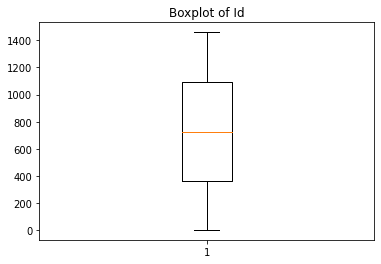

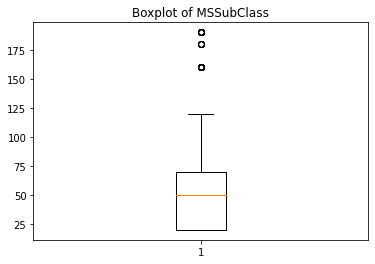

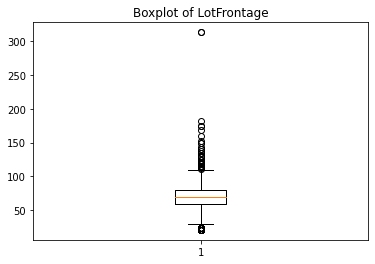

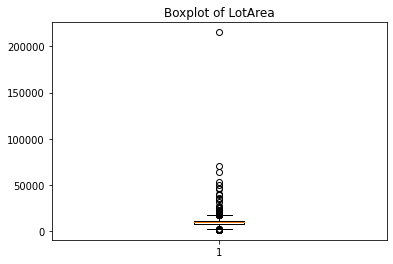

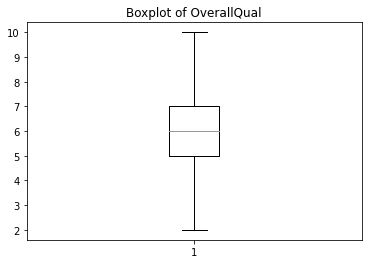

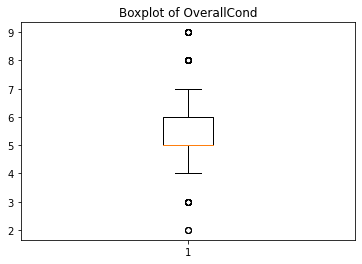

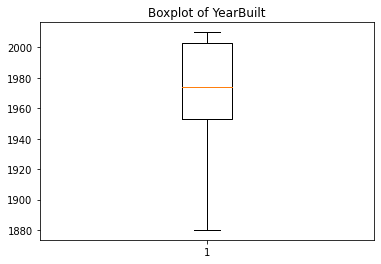

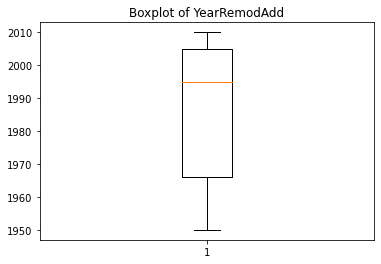

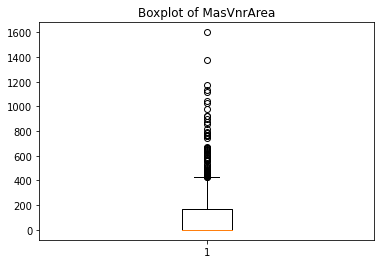

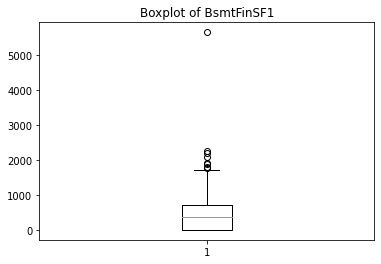

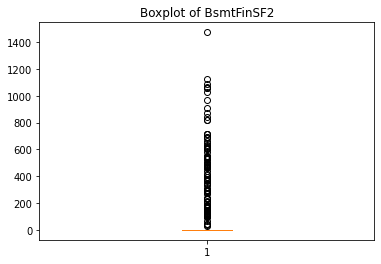

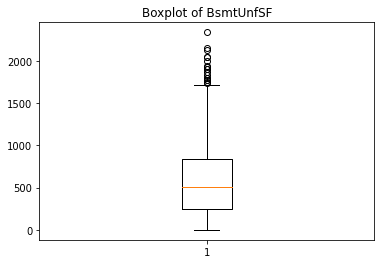

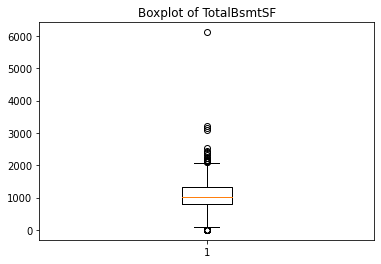

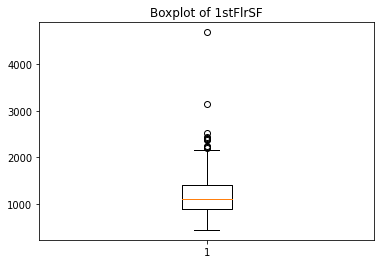

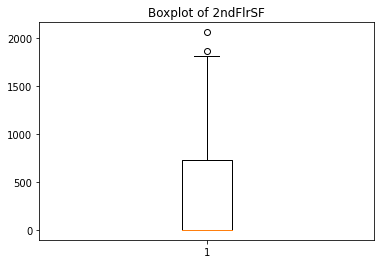

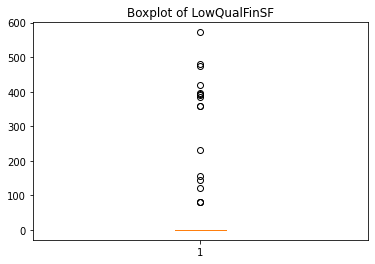

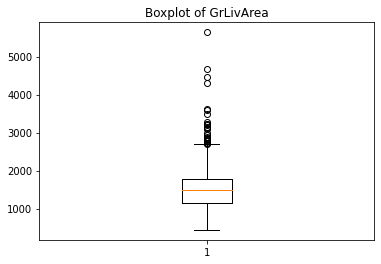

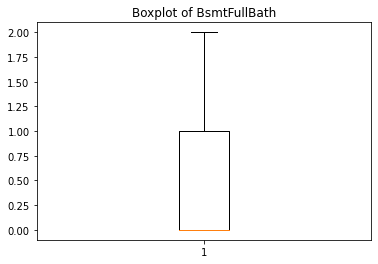

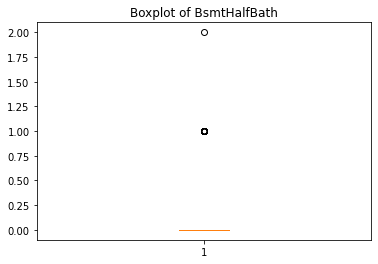

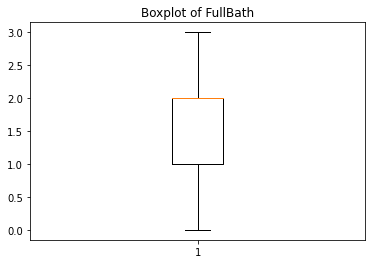

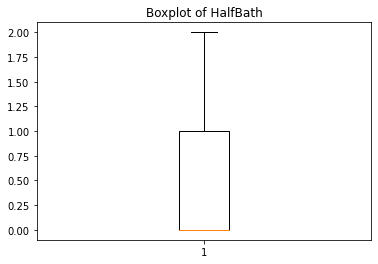

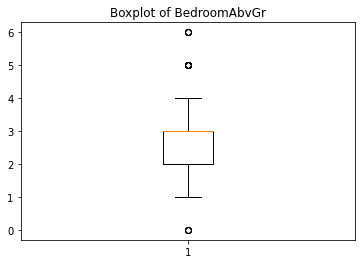

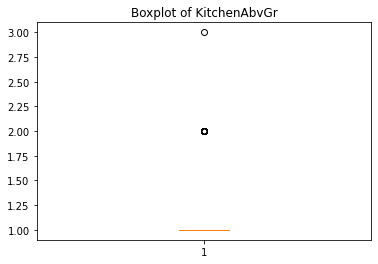

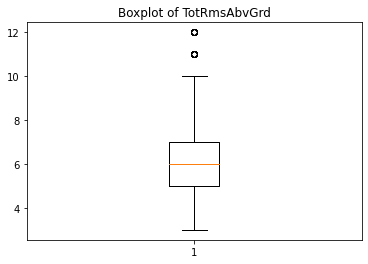

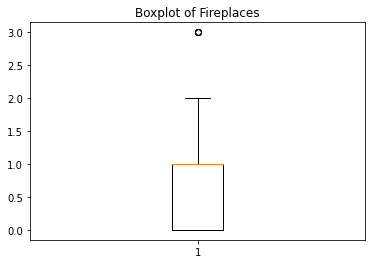

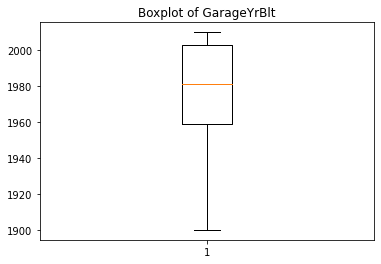

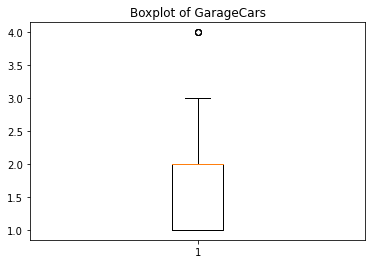

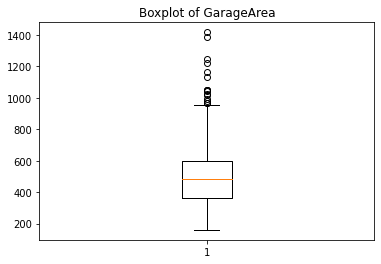

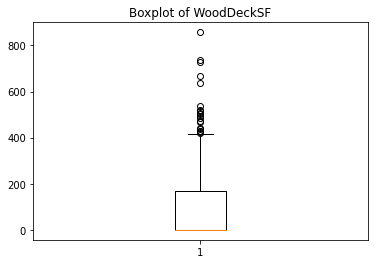

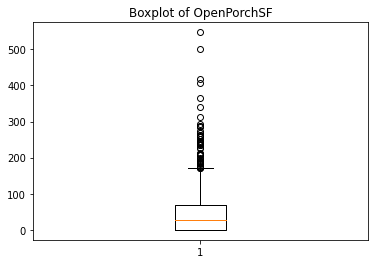

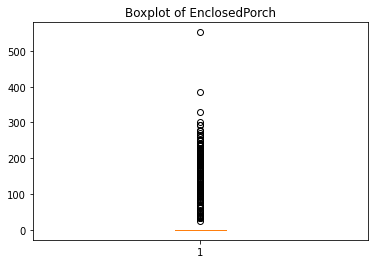

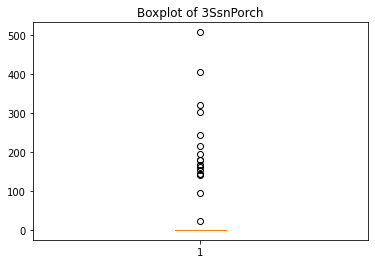

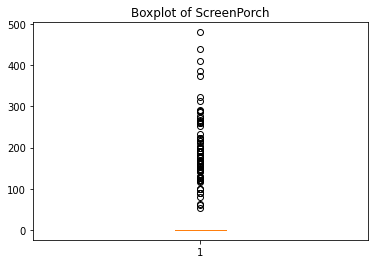

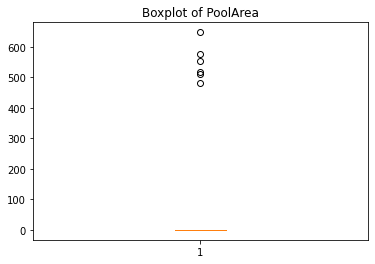

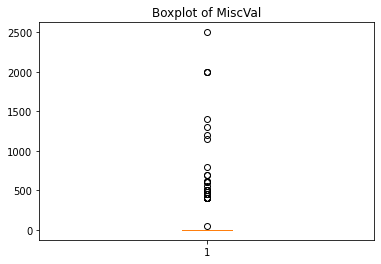

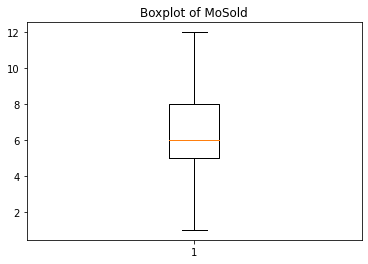

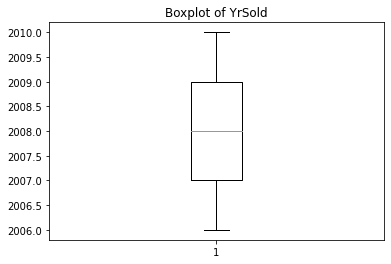

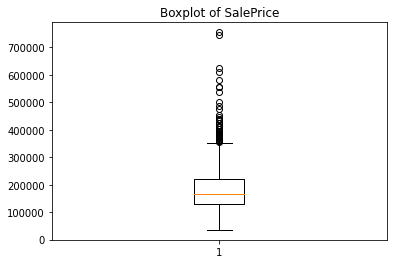

In [11]:
for i in data:
    try:
        Box(data[i],i)
    except:
        pass

## 2.3 Erasing outliers

For the following steps we need to treat the dataset. First we drop the ID column as we don't need them. After that we apply the 'detect_outliers_iqr()' function, that remove the outliers for each feature, and visualize the resulting dataset and their boxplot charts.

To make the most of the data we delete the outliers in the dataset. There are several techniques used to treat outliers, such as the z-score, the InterQuartile Range (IQR), the outlier fences or a hypothesis test. For simplicity in this project, we decided to just erase the outliers that are lower than Q1-(2$\cdot$IQR) or greater than Q3+(2*$\cdot$IQR)using the InterQuartile Range (IQR).

In [12]:
data=data[data.columns[1:]].copy()
data=detect_outliers_iqr(data)
data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,366,0,112,0,0,0,0,4,2010,142125


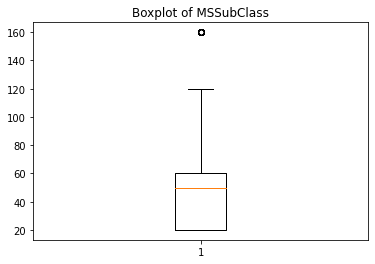

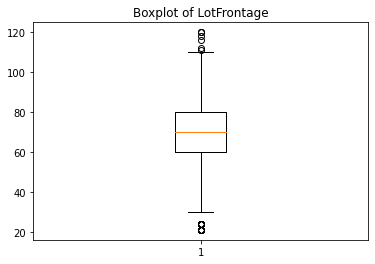

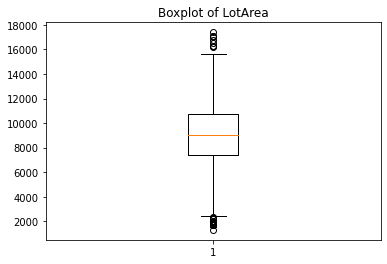

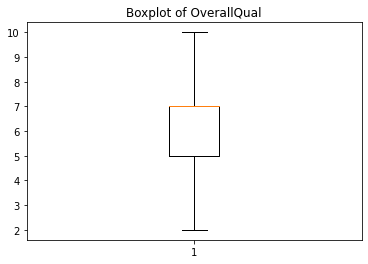

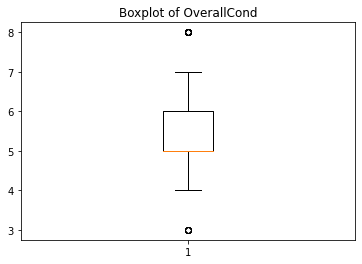

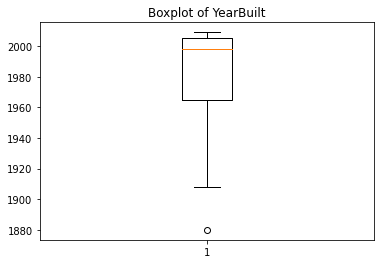

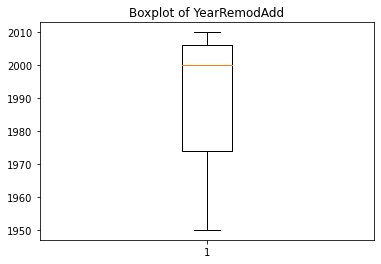

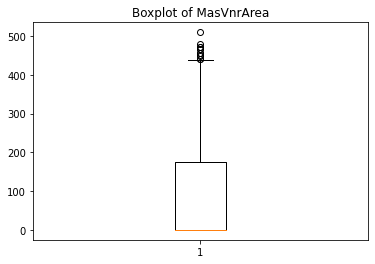

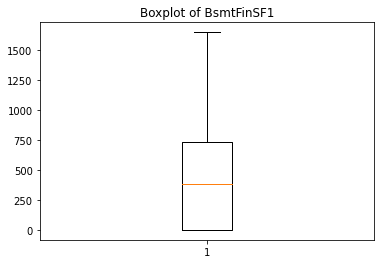

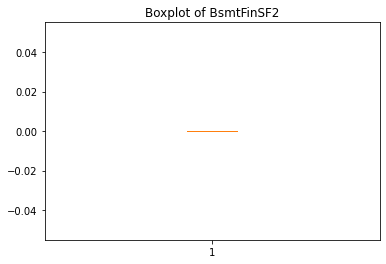

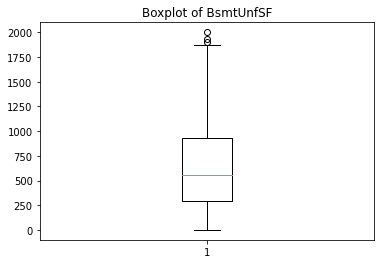

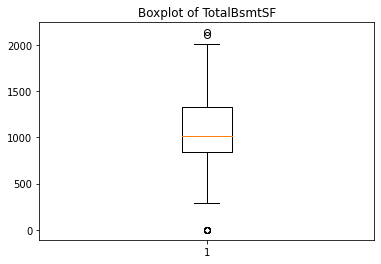

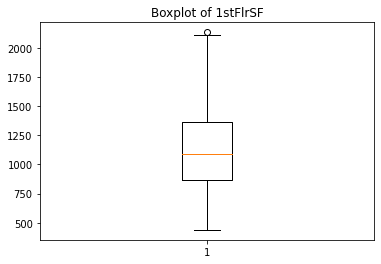

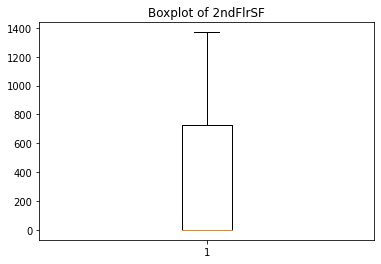

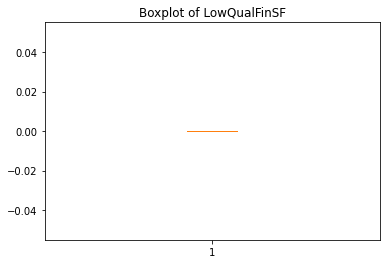

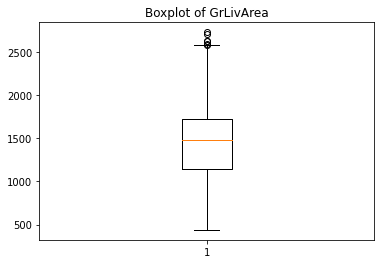

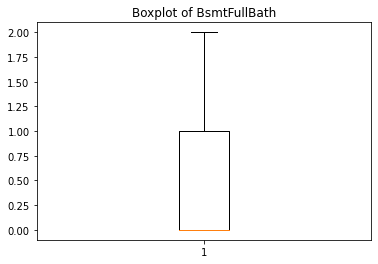

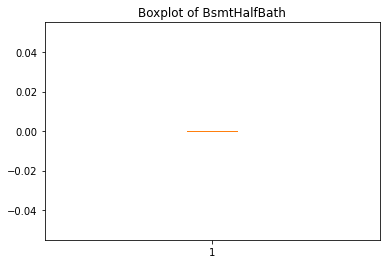

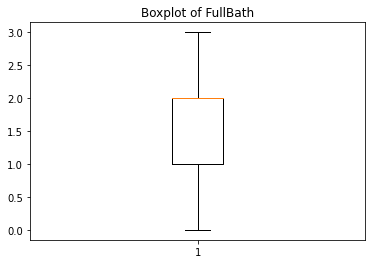

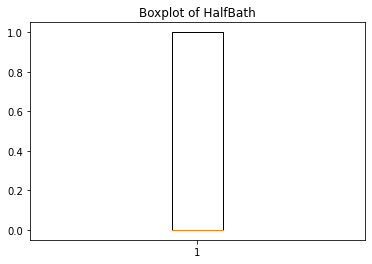

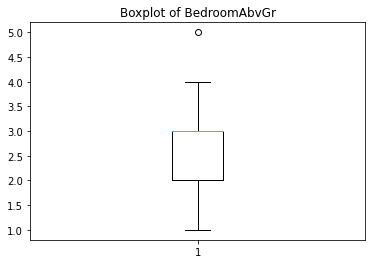

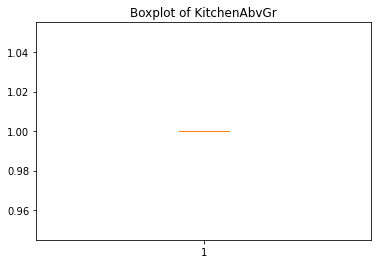

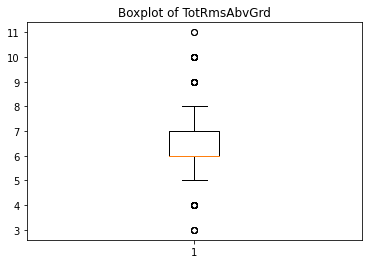

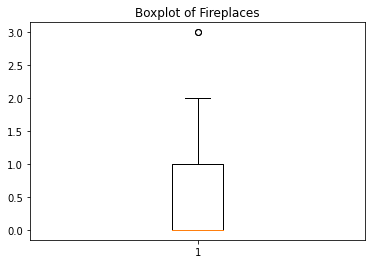

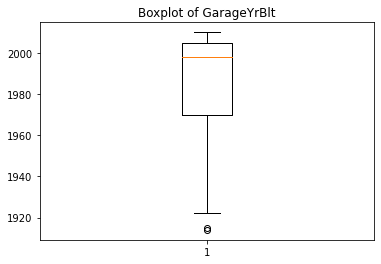

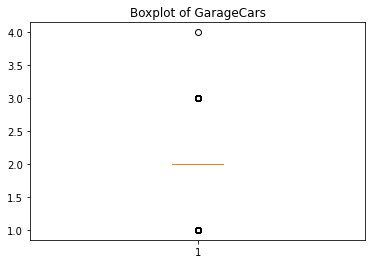

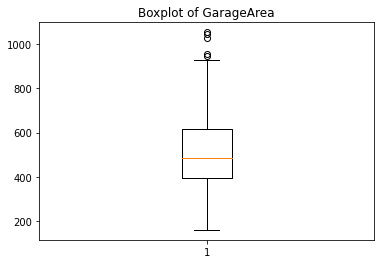

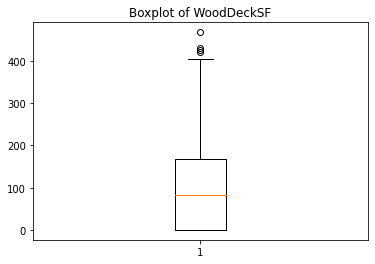

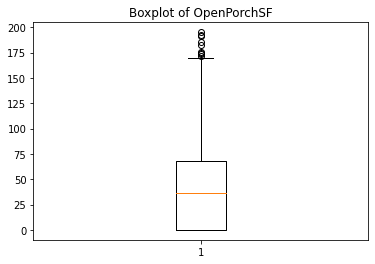

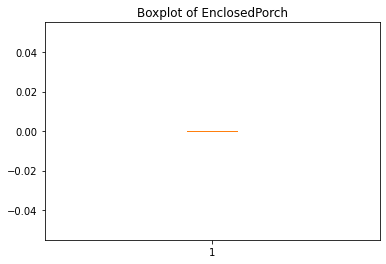

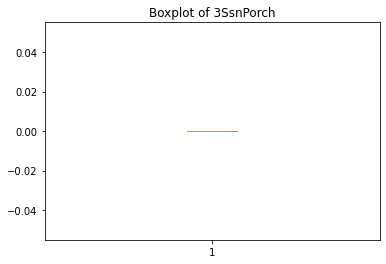

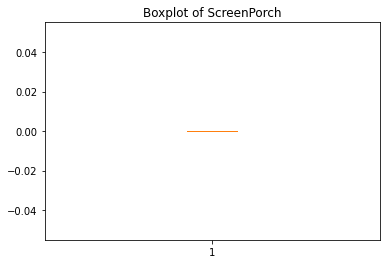

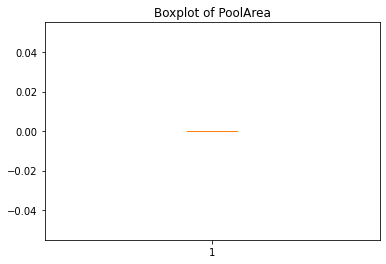

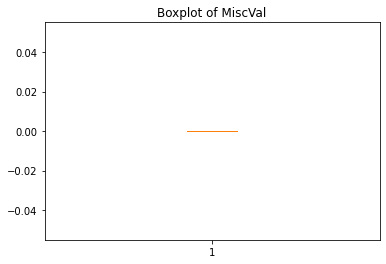

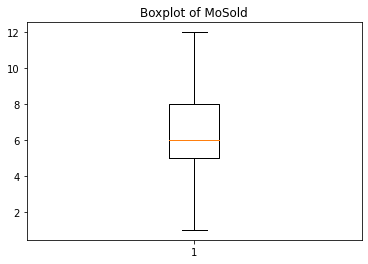

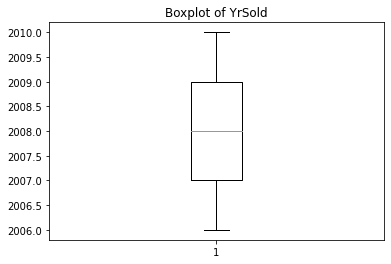

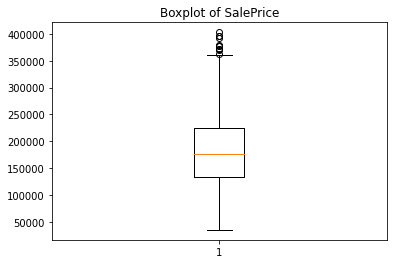

In [14]:
for i in data:
    try:
        Box(data[i],i)
    except:
        pass

Also, we made proofs with the z-score to eliminate outliers, but this metric couldn't improve the performance of the model in the realized proofs.

If you want to make it by yourself you only need to change the 'detect_outliers_iqr()' funtion for the 'detect_outliers_zscore()' function.

## 2.4 More visualization and correlation of the data

Next we want to visualize the correlation plot to see which features have a strong correlation with the 'sale price' label.

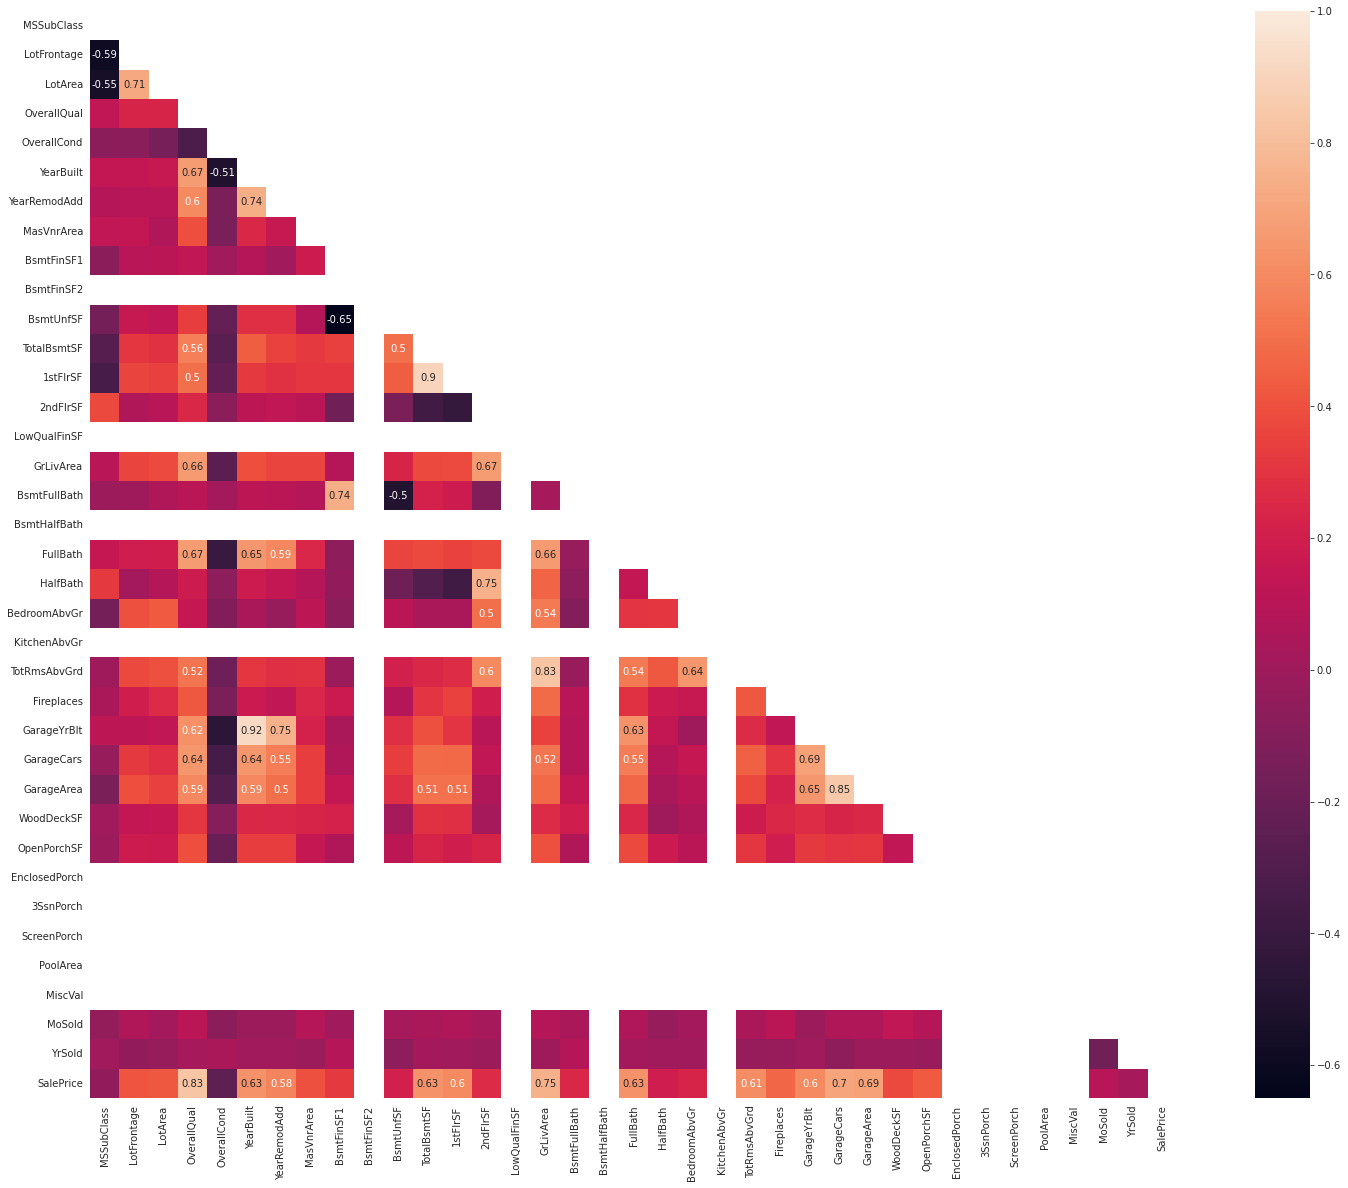

In [15]:
valor_max=0.5

correlation_matrix = data.corr().round(2)

labels=correlation_matrix.applymap(lambda x: str(x) if x>=valor_max or x<=-valor_max else '')

mask=np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(28, 20))
    ax = sns.heatmap(correlation_matrix, annot=labels, mask=mask, vmax=1, square=True, fmt='')

## 2.5 backward elimination
With the data that passed the filter, we applied a null hypothesis test to determine the correlation between the characteristics and the labels. The null hypothesis probed is that the selected combination of dependent variables does not have any effect on the independent variable. With the associated p-values we selected which characteristics would be passed as parameters in the multiple linear regression. If the p-values are higher that the threshold (selection criteria) the combination of features are discarded. This technique is known as backward elimination.

The following step is the preparation of the dataset making the split of training and testing sets. After that we are going to make a backward elimination with the 'backwardElimination()' function to select the most relevant features acording to their p-value resulting of a null hypothesis test that check the correlation between the features and the label.

In [16]:
X=data[numerical_data[1:-1]].copy()
Y=data[numerical_data[-1:]].copy()

In [17]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(X.values, 
                                                     Y.values, 
                                                     SL, 
                                                     numerical_data[1:-1])

C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [18]:
for i in range(5):
    X_train,Y_train,X_test,Y_test=Data_preparation(features=list(selected_columns),
                                                   labels=['SalePrice'],
                                                   data=data,
                                                   split_ratio=0.2)

    train_model=Train_model(x_train=X_train,
                            y_train=Y_train,
                            x_test=X_test,
                            y_test=Y_test,
                           param_score=0.85)

len train set: 448
len test set: 112
**---Model saved with R^2 of: 0.8713---**
r2 score is:  0.8713152438816575
**************************
len train set: 448
len test set: 112
**---Model saved with R^2 of: 0.8914---**
r2 score is:  0.8914010127531026
**************************
len train set: 448
len test set: 112
r2 score is:  0.842779416161016
**************************
len train set: 448
len test set: 112
**---Model saved with R^2 of: 0.9025---**
r2 score is:  0.9025489542283597
**************************
len train set: 448
len test set: 112
r2 score is:  0.8417005819276886
**************************


p-values sometimes can fail predicting variables that are correlated and in general terms this is not the best way to select the most relevant features but in this case they performed well.

## 2.6 More proofs

Also we make another proof taking the features with a correlation greater than 0.5 instead of the p-values, only to see the results.

In [19]:
All_interestying_descriptors=[]

c=0
for i in data.corr()['SalePrice'].round(2):
    if abs(i)>=0.5 and i !=1:
        All_interestying_descriptors.append(numerical_data[c+2])
        print(i,numerical_data[c+2])
    c+=1
    
All_interestying_descriptors

0.83 OverallCond
0.63 YearRemodAdd
0.58 MasVnrArea
0.63 1stFlrSF
0.6 2ndFlrSF
0.75 BsmtFullBath
0.63 HalfBath
0.61 Fireplaces
0.6 GarageCars
0.7 GarageArea
0.69 WoodDeckSF


['OverallCond',
 'YearRemodAdd',
 'MasVnrArea',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF']

In [20]:
for i in range(5):
    X_train,Y_train,X_test,Y_test=Data_preparation(features=list(All_interestying_descriptors),
                                                   labels=['SalePrice'],
                                                   data=data,
                                                   split_ratio=0.2)

    train_model=Train_model(x_train=X_train,
                            y_train=Y_train,
                            x_test=X_test,
                            y_test=Y_test,
                           param_score=0.85)

len train set: 448
len test set: 112
r2 score is:  0.8401976994507736
**************************
len train set: 448
len test set: 112
r2 score is:  0.7860131914440064
**************************
len train set: 448
len test set: 112
r2 score is:  0.7985623079934959
**************************
len train set: 448
len test set: 112
**---Model saved with R^2 of: 0.8679---**
r2 score is:  0.8678545688159208
**************************
len train set: 448
len test set: 112
r2 score is:  0.8218883516549034
**************************


## 2.7 Conclusions

The best results are obtained when outliers are removed and then backward elimination is applied, before training the model. This can lead to a correlation coefficient of 0.89.

The variation in the results is since each time a test is performed, the training and test groups are randomly selected, which affects the performance of the model.

We can also conclude that among the factors analyzed, one of those that most affects the performance of the data is the elimination of outliers. 

Also, it is relevant to notice that p-values sometimes can fail predicting variables that are correlated and in general terms this is not the best way to select the most relevant features but in this case they performed well.


### Bibliography:

https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155

https://www.kaggle.com/mahyamahjoob/advance-house-price-prediction

https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/

https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

https://stats.stackexchange.com/questions/291210/is-it-wrong-to-choose-features-based-on-p-value/291239#291239

https://statisticsbyjim.com/basics/outliers/

https://www.statisticshowto.com/probability-and-statistics/z-score/